In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from pathlib import Path
from typing import Iterable, Tuple, List, Any
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn

In [2]:
!pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')
import scipy.stats as ss
import pandas as pd

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

Начнем изучение NLP с понятной задачи - предсказание сантимента. 

## Prepare Data [ 1 балла]

- Для начала необходимо преобразовать данные 
- Напишите функцию, которая читает файл и возвращает объект класса SentimentData (Постарайтесь сделать функцию-итератор, которая бы не клала объекты в память)
- Напишите функцию preprocess (минимальный объем препроцессинга в комментарии к функции)

In [5]:
data_path = Path("animal-crossing_reviews.csv")

In [6]:
from dataclasses import dataclass

@dataclass
class SentimentData:
    sentence: str
    sentiment: int

In [7]:
def extract_lines(path: Path) -> Iterable[SentimentData]:
    with open(path) as src:
        reader = csv.DictReader(src, delimiter=',')
        for line in reader:
          #grade, user_name, text, date = line
          yield SentimentData(line["text"], int(line["grade"]) >= 5)


In [8]:
import string
def preprocess(lines: Iterable[SentimentData]) -> Iterable[SentimentData]:
    """
    - Lowercase sentence
    - Do tokenization with nltk.wordpunct_tokenize
    - normalize words
    - delete stop words
    - join using tokens with space
    - yield it to next generator
    """
    stopWords = set(stopwords.words(['english', 'russian']))
    punct = set(",.:;'")
    stopWords = stopWords | punct
    for line in lines:
      sentence = line.sentence.lower()
      grade = line.sentiment
      sentence = nltk.wordpunct_tokenize(sentence)
      # lemming ?
      # stemming ?
      wnl = WordNetLemmatizer()
      
      sentence = " ".join([wnl.lemmatize(word) for word in sentence 
                           if wnl.lemmatize(word) not in stopWords])
      yield SentimentData(sentence, grade)


In [9]:
writer = extract_lines(data_path)
preprocessed = preprocess(writer)

In [10]:
sentences = list(preprocessed)

In [11]:
assert [sent.sentence for sent in sentences[::1000]] == ['gf started playing option create island guy 2nd player start console suck !!!! miss much 1st player get term activity resource etc absolutely terrible buy 2nd console one person household want get full game experience unacceptable',
                                                         'game undeniably adorable super fun unless like second player switch system game lock consequential decision wait player one progress passive resident island way get full experience another switch system absolutely acceptable ha destroyedthis game undeniably adorable super fun unless like second player switch system game lock consequential decision wait player one progress passive resident island way get full experience another switch system absolutely acceptable ha destroyed fun wa game .… expand',
                                                         'sad find second player like slave first player stop playing get fixed']

- Пора разбить данные на тренировочную и тестовую выборку

In [12]:
train, test = train_test_split(sentences, test_size=0.2, random_state=42)

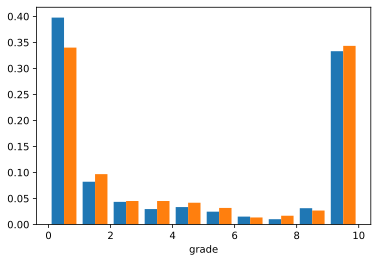

In [ ]:
plt.hist([np.array([t.sentiment for t in train]), np.array([t.sentiment for t in test])], density=True)
plt.xlabel("grade")
plt.show()

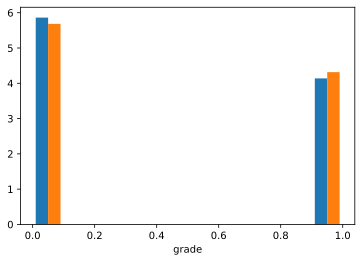

In [ ]:
plt.hist([np.array([t.sentiment for t in train]), np.array([t.sentiment for t in test])], density=True)
plt.xlabel("grade")
plt.show()

In [ ]:
(np.array([t.sentiment for t in test]) == 1).mean()

0.43166666666666664

## TFIDF + Logistic Regression [ 2 балла]

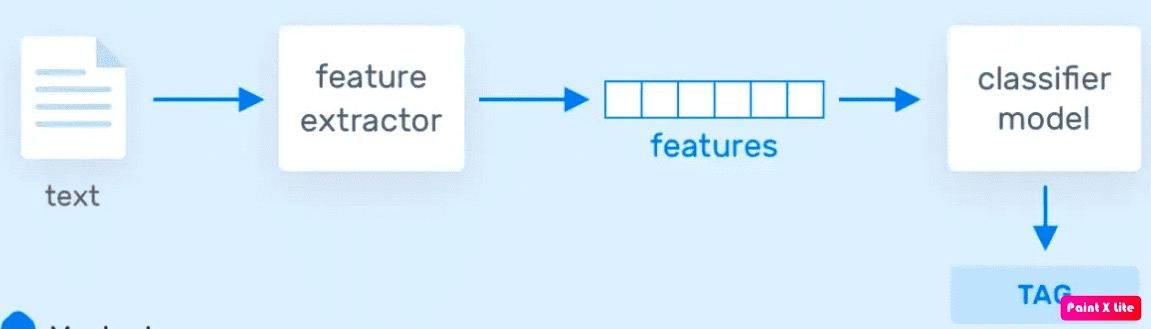

#### TF-IDF
$TF$ - частота встречания терма (term frequency)<br>
$IDF$ - обратная частота встречания терма в документах (invert document frequency)

$$tf_{i, j} = \frac{N_i}{\sum\limits_j N_j}$$<br>
$$idf_{i} = log(\frac{|D|}{|\{d_k \in D | i \in d_k \}|}) \approx log (\frac{|D|}{df(i) + 1}) \approx log (\frac{|D| + 1}{df(i) + 1}) + 1$$

In [13]:
def split_on_x_y(data: List[SentimentData]) -> Tuple[List[str], List[int]]:
    X, y = [sdata.sentence for sdata in data], [sdata.sentiment for sdata in data]
    return X, y

In [14]:
X_train, y_train = split_on_x_y(train)
X_test, y_test = split_on_x_y(test)

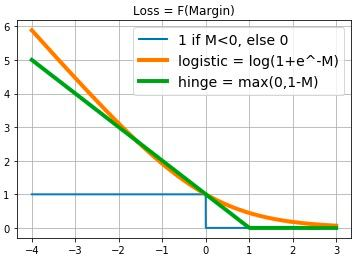

$$Q(w) = \sum_{i = 0}^{|D|} log(1 + exp(-y_i<x_i * w>)) -> min_w$$ - функция потерь

$$p(y|x) = \sigma(x,w) = \frac{1}{1 + e^{-xw}}$$ - апостериорная вероятность класса

- Создайте sklearn'вский pipeline с предобработкой текста и LogisticRegression
- Добавьте GridSearchCV для настройки коэффициентов LR

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [151]:
cv = CountVectorizer(ngram_range=(1,2))
X = cv.fit_transform(X_test)
print(X.toarray().shape)
cv.get_feature_names_out()

(600, 25483)


array(['000', '000 bell', '000 debt', ..., '有的交互甚至比端游还差例如',
       '有的交互甚至比端游还差例如 我想按一下爆米花机玩玩', '比如咖啡机村民直接把头按进去喝'], dtype=object)

In [154]:
pipeline = Pipeline(
    [('vect', CountVectorizer(ngram_range=(1,1))),
     ('tf-idf', TfidfTransformer()),
     ('logreg_grid_search', GridSearchCV(estimator = LogisticRegression(),
                                         param_grid={'C': [0.1, 0.5, 1, 5, 10.0]}))
     ]
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tf-idf', TfidfTransformer()),
                ('logreg_grid_search',
                 GridSearchCV(estimator=LogisticRegression(),
                              param_grid={'C': [0.1, 0.5, 1, 5, 10.0]}))])

In [155]:
print('test')
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["negative", "positive"]))
print('train')
y_pred = pipeline.predict(X_train)
print(classification_report(y_train, y_pred, target_names=["negative", "positive"]))

test
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88       341
    positive       0.87      0.80      0.83       259

    accuracy                           0.86       600
   macro avg       0.86      0.85      0.86       600
weighted avg       0.86      0.86      0.86       600

train
              precision    recall  f1-score   support

    negative       0.94      0.96      0.95      1406
    positive       0.94      0.91      0.92       993

    accuracy                           0.94      2399
   macro avg       0.94      0.93      0.94      2399
weighted avg       0.94      0.94      0.94      2399



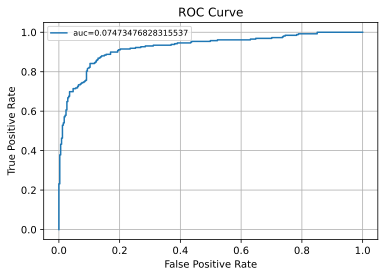

In [156]:
from sklearn import metrics

scores = pipeline.predict_proba(X_test).T[1]
tpr, fpr, _ = metrics.roc_curve(y_test, scores)

plt.plot(tpr, fpr, label="auc={}".format(metrics.auc(fpr, tpr)))
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(fontsize=8)
plt.grid()

plt.show()

- Если Вы никогда не имели дело с PyTorch, то переходим в ноутбук PyTorch Intro.ipnyb

## Going to Pytorch [ 3 балла ]

- Давайте создадим кастомный датасет для удобной загрузки данных

In [22]:
from torch.utils.data import Dataset
class CustomTagDataset(Dataset):
    """
    - CustomTagDataset должен быть наследником torch.utils.data.Dataset, чтобы в полной мере наследовать все возможности
    - Датасет должен принимать sentences: List[str], target: List[int] и feature_extractor: Pipeline - pipeline для выделения признаков из текста
    - Напишите функцию __len__ объявляющие длину вашего датасета
    - Напишите функцию _extract_features
    - Напишите функцию __getitem__ которая будет по индексу возвращаться словарь {'feat': tensor_of_features, 'target': tensor_of_target} все dtype=torch.float
    
    """
    def __init__(self, sentences: List[str], target: List[int], feature_extractor: Pipeline, test: bool = False):
        self._data = sentences
        self._target = target
        self._features_pipeline = feature_extractor
        self._features = self._extract_features(test)

    def __getitem__(self, idx: int):
        return {"feat": self._features[idx],
                "target": self._target[idx]
               }
    
    def _extract_features(self, is_test):
        if is_test:
          return torch.Tensor(self._features_pipeline.transform(self._data).toarray())
        else:
          return torch.Tensor(self._features_pipeline.fit_transform(self._data).toarray())
    
    def __len__(self):
        return len(self._data)

In [35]:
from torch.utils.data import DataLoader
features = Pipeline(
    [('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer())]
)

data_train = DataLoader(CustomTagDataset(X_train, y_train, features, test=False), batch_size=16, shuffle=True)
data_test = DataLoader(CustomTagDataset(X_test, y_test, features, test=True), batch_size=16, shuffle=True)

In [55]:
class SimpleNNForClassification(nn.Module):
    """
    - Напишите слои нейронной сети
      - Линейный слой из tfidf_feature_size в out_features
      - ReLU
      - Линейный слой преобразующий in_features в out_features
      - ReLU
      - Линейный слой преобразующий in_features в тензор размеров 1 
    - Напишите forward 
    """
    def __init__(self, tfidf_feature_size: int):
        super(SimpleNNForClassification, self).__init__()
        out_features = 300
        in_features = 300
        self.layer1 = nn.Linear(tfidf_feature_size, out_features)
        self.layer2 = nn.Linear(out_features, in_features)
        self.layer3 = nn.Linear(in_features, 1)
        self.layer4 = nn.Linear(tfidf_feature_size, 1)
        self.fc = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, input):
        out = self.layer1(input)
        out = self.fc(out)
        out = self.layer2(out)
        out = self.fc(out)
        out = self.layer3(out)
        
        #out = self.layer4(input)
        return out

In [37]:
import tqdm

BATCH_SIZE = 16
EPOCHS = 5
DEVICE = torch.device('cpu')

In [38]:
@torch.no_grad()
def print_metrics(model, test_data):
    """
    - напишите часть инференса
      - передайте в модель батч с признаками
      - чтобы превратить logit-вектора в 'вероятности' примените сигмоидную функцию
      - посчитайте получившиеся значения сантиментов с помощью трешхолда = 0.5
    """
    preds = []
    targets = []
    sigm = nn.Sigmoid()
    for i, batch in tqdm.notebook.tqdm(enumerate(test_data)):
        feats, labels = batch['feat'], batch['target']
        pred = [_ for _ in sigm(model(feats)).numpy().ravel() > 0.5]
        target = [_ for _ in labels.type(torch.long).numpy()]
        preds += pred
        targets += target

    print(classification_report(targets, preds, target_names=["negative", "positive"], zero_division=0))

In [39]:
import torch.nn.functional as F
import tqdm

In [40]:
def calc_loss(logit, target):
  target = 2 * (target - 0.5)
  return torch.log(1 + torch.exp(-logit * target[:, None])).sum()

In [100]:
def train(model: nn.Module,
          train_data: List[Any], 
              test_data: List[Any] = None, 
          epochs: int = 5, 
          batch_size: int = 16):
    """
    - напишите часть обучения для модели 
      - передайте в модель батч с признаками
      - посчитайте лосс
      - вызовите backward propagation
    """
    
    model.to(DEVICE)
    criterion = calc_loss
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    sigm = nn.Sigmoid()
    
    if test_data is not None:
        print_metrics(model, test_data)
    
    total_step = len(train_data)
    losses = []

    for epoch in range(epochs):
        #print(f"epoch: {epoch}")
        model.train()
        for i, batch in tqdm.notebook.tqdm(enumerate(train_data)):
            feats, labels = batch['feat'], batch['target']
            #feats = feats.to(DEVICE) 
            #labels = labels.to(DEVICE)

            # forward pass
            preds = model(feats)
            loss = criterion(preds, labels.type(torch.long))


            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            if (i+1) % 10 == 0:
              losses.append(loss.item())
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, epochs, i+1, total_step, loss.item()))

        if test_data is not None:
            print_metrics(model, test_data)

    return losses

In [42]:
def set_seed(random_seed: int = 37):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)

In [76]:
set_seed()

In [77]:
features["tfidf"].idf_.shape

(9361,)

In [101]:
model = SimpleNNForClassification(features["tfidf"].idf_.shape[0])
losses = train(model, data_train, data_test, 5)

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       341
    positive       0.43      1.00      0.60       259

    accuracy                           0.43       600
   macro avg       0.22      0.50      0.30       600
weighted avg       0.19      0.43      0.26       600



0it [00:00, ?it/s]

Epoch [1/5], Step [10/150], Loss: 10.8917
Epoch [1/5], Step [20/150], Loss: 10.4737
Epoch [1/5], Step [30/150], Loss: 9.4375
Epoch [1/5], Step [40/150], Loss: 9.9078
Epoch [1/5], Step [50/150], Loss: 5.8946
Epoch [1/5], Step [60/150], Loss: 3.2803
Epoch [1/5], Step [70/150], Loss: 1.8487
Epoch [1/5], Step [80/150], Loss: 0.6524
Epoch [1/5], Step [90/150], Loss: 5.6408
Epoch [1/5], Step [100/150], Loss: 9.2282
Epoch [1/5], Step [110/150], Loss: 9.0007
Epoch [1/5], Step [120/150], Loss: 6.7751
Epoch [1/5], Step [130/150], Loss: 3.9198
Epoch [1/5], Step [140/150], Loss: 1.3233
Epoch [1/5], Step [150/150], Loss: 4.4494


0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.89      0.87      0.88       341
    positive       0.83      0.85      0.84       259

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



0it [00:00, ?it/s]

Epoch [2/5], Step [10/150], Loss: 1.5654
Epoch [2/5], Step [20/150], Loss: 1.4794
Epoch [2/5], Step [30/150], Loss: 2.6844
Epoch [2/5], Step [40/150], Loss: 0.5191
Epoch [2/5], Step [50/150], Loss: 0.6136
Epoch [2/5], Step [60/150], Loss: 0.3179
Epoch [2/5], Step [70/150], Loss: 0.7753
Epoch [2/5], Step [80/150], Loss: 0.3145
Epoch [2/5], Step [90/150], Loss: 1.8625
Epoch [2/5], Step [100/150], Loss: 0.1695
Epoch [2/5], Step [110/150], Loss: 0.5616
Epoch [2/5], Step [120/150], Loss: 6.2383
Epoch [2/5], Step [130/150], Loss: 2.3450
Epoch [2/5], Step [140/150], Loss: 8.3680
Epoch [2/5], Step [150/150], Loss: 0.1713


0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.89      0.85      0.87       341
    positive       0.81      0.86      0.84       259

    accuracy                           0.86       600
   macro avg       0.85      0.86      0.85       600
weighted avg       0.86      0.86      0.86       600



0it [00:00, ?it/s]

Epoch [3/5], Step [10/150], Loss: 1.0757
Epoch [3/5], Step [20/150], Loss: 0.1641
Epoch [3/5], Step [30/150], Loss: 0.0838
Epoch [3/5], Step [40/150], Loss: 0.1038
Epoch [3/5], Step [50/150], Loss: 0.1579
Epoch [3/5], Step [60/150], Loss: 0.0942
Epoch [3/5], Step [70/150], Loss: 0.1801
Epoch [3/5], Step [80/150], Loss: 3.7090
Epoch [3/5], Step [90/150], Loss: 0.1087
Epoch [3/5], Step [100/150], Loss: 0.0597
Epoch [3/5], Step [110/150], Loss: 0.1789
Epoch [3/5], Step [120/150], Loss: 0.0818
Epoch [3/5], Step [130/150], Loss: 0.2821
Epoch [3/5], Step [140/150], Loss: 0.3733
Epoch [3/5], Step [150/150], Loss: 0.0579


0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.85      0.91      0.88       341
    positive       0.87      0.80      0.83       259

    accuracy                           0.86       600
   macro avg       0.86      0.85      0.86       600
weighted avg       0.86      0.86      0.86       600



0it [00:00, ?it/s]

Epoch [4/5], Step [10/150], Loss: 0.6694
Epoch [4/5], Step [20/150], Loss: 0.0222
Epoch [4/5], Step [30/150], Loss: 0.0344
Epoch [4/5], Step [40/150], Loss: 0.0852
Epoch [4/5], Step [50/150], Loss: 0.0159
Epoch [4/5], Step [60/150], Loss: 0.0201
Epoch [4/5], Step [70/150], Loss: 0.0356
Epoch [4/5], Step [80/150], Loss: 0.0465
Epoch [4/5], Step [90/150], Loss: 0.0156
Epoch [4/5], Step [100/150], Loss: 0.0170
Epoch [4/5], Step [110/150], Loss: 0.0374
Epoch [4/5], Step [120/150], Loss: 0.0271
Epoch [4/5], Step [130/150], Loss: 0.0142
Epoch [4/5], Step [140/150], Loss: 0.0088
Epoch [4/5], Step [150/150], Loss: 0.0241


0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.86      0.89      0.88       341
    positive       0.85      0.80      0.83       259

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



0it [00:00, ?it/s]

Epoch [5/5], Step [10/150], Loss: 0.0169
Epoch [5/5], Step [20/150], Loss: 0.0064
Epoch [5/5], Step [30/150], Loss: 0.0160
Epoch [5/5], Step [40/150], Loss: 0.0114
Epoch [5/5], Step [50/150], Loss: 0.0382
Epoch [5/5], Step [60/150], Loss: 0.0102
Epoch [5/5], Step [70/150], Loss: 0.1063
Epoch [5/5], Step [80/150], Loss: 0.0065
Epoch [5/5], Step [90/150], Loss: 0.0083
Epoch [5/5], Step [100/150], Loss: 0.0065
Epoch [5/5], Step [110/150], Loss: 0.0076
Epoch [5/5], Step [120/150], Loss: 0.0069
Epoch [5/5], Step [130/150], Loss: 0.0627
Epoch [5/5], Step [140/150], Loss: 0.0008
Epoch [5/5], Step [150/150], Loss: 0.0046


0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.86      0.89      0.87       341
    positive       0.84      0.81      0.83       259

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



### Результаты

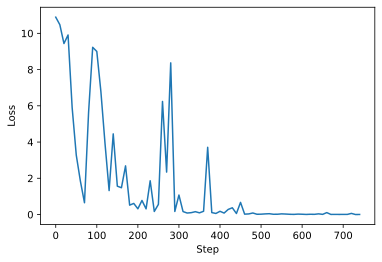

In [102]:
plt.plot(10 * np.arange(len(losses)), np.array(losses))
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [103]:
print_metrics(model, data_test) # test

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.86      0.89      0.87       341
    positive       0.84      0.81      0.83       259

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



In [104]:
print_metrics(model, data_train) # train (overfitting)

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      1406
    positive       1.00      1.00      1.00       993

    accuracy                           1.00      2399
   macro avg       1.00      1.00      1.00      2399
weighted avg       1.00      1.00      1.00      2399



### Prevent Overfitting [ 2 балла ]

- Как видно выше модель очень быстро переобучается, так давайте применим все те широкоизвестные методы,чтобы этого избежать
- Считайте качество на валидационной выборке
- Можете воспользоваться Early Stopping'ом
- Добавить регуляризацию в модель
- Все что Ваша фантазия Вам позволяет - делайте

In [191]:
from torch.utils.data import DataLoader
features = Pipeline(
    [('vect', CountVectorizer(ngram_range=(1,1), max_features=300)),
     ('tfidf', TfidfTransformer())]
)

data_train = DataLoader(CustomTagDataset(X_train, y_train, features, test=False), batch_size=16, shuffle=True)
data_test = DataLoader(CustomTagDataset(X_test, y_test, features, test=True), batch_size=16, shuffle=True)

In [192]:
class RegularizedNNForClassification(nn.Module):

    def __init__(self, tfidf_feature_size: int):
        super(RegularizedNNForClassification, self).__init__()
        out_features = 500
        in_features = 500
        self.linear1 = nn.Linear(tfidf_feature_size, out_features)
        self.linear2 = nn.Linear(out_features, in_features)
        self.linear3 = nn.Linear(in_features, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, input):
        out = self.linear1(input)
        out = self.dropout(out)
        out = self.relu(out)

        out = self.linear2(out)
        out = self.dropout(out)
        out = self.relu(out)

        out = self.linear3(out)

        return out

In [193]:
set_seed()


In [194]:
features["tfidf"].idf_.shape

(300,)

In [195]:
model = RegularizedNNForClassification(features["tfidf"].idf_.shape[0])
losses = train(model, data_train, data_test, 1)

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.57      0.68      0.62       341
    positive       0.43      0.32      0.37       259

    accuracy                           0.53       600
   macro avg       0.50      0.50      0.49       600
weighted avg       0.51      0.53      0.51       600



0it [00:00, ?it/s]

Epoch [1/1], Step [10/150], Loss: 10.8784
Epoch [1/1], Step [20/150], Loss: 10.0909
Epoch [1/1], Step [30/150], Loss: 10.1021
Epoch [1/1], Step [40/150], Loss: 9.6907
Epoch [1/1], Step [50/150], Loss: 7.8836
Epoch [1/1], Step [60/150], Loss: 7.4904
Epoch [1/1], Step [70/150], Loss: 3.8196
Epoch [1/1], Step [80/150], Loss: 5.1513
Epoch [1/1], Step [90/150], Loss: 4.9276
Epoch [1/1], Step [100/150], Loss: 6.0720
Epoch [1/1], Step [110/150], Loss: 3.5067
Epoch [1/1], Step [120/150], Loss: 6.6972
Epoch [1/1], Step [130/150], Loss: 3.4851
Epoch [1/1], Step [140/150], Loss: 5.9440
Epoch [1/1], Step [150/150], Loss: 3.1473


0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.88      0.86      0.87       341
    positive       0.82      0.85      0.83       259

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



### Результаты

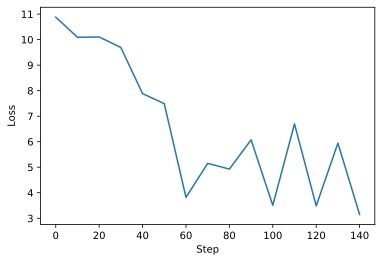

In [196]:
plt.plot(10 * np.arange(len(losses)), np.array(losses))
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [197]:
print_metrics(model, data_test) # test

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.87      0.86      0.86       341
    positive       0.81      0.83      0.82       259

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.85      0.84      0.85       600



In [198]:
print_metrics(model, data_train) # train

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    negative       0.93      0.90      0.91      1406
    positive       0.87      0.90      0.88       993

    accuracy                           0.90      2399
   macro avg       0.90      0.90      0.90      2399
weighted avg       0.90      0.90      0.90      2399



### Beat Logistic Regression [ 2 балла ]

- Задание одной картинкой

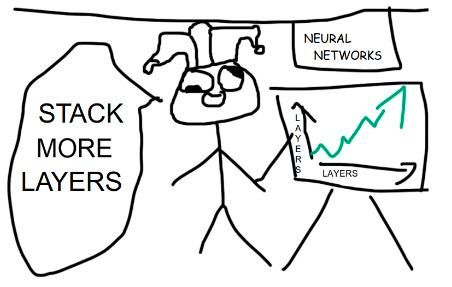

На самом деле нет
- Подумайте как можно улучшить выделение признаков из текста
- Stack More Layers